In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.offline import iplot

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report,roc_curve, auc

import tensorflow as tf
import keras 
from keras.models import Sequential
from keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import MaxPooling2D, Flatten, Dense,BatchNormalization,GlobalAveragePooling2D,Conv2D,Dropout,Flatten,Rescaling,Input
from keras import regularizers
from keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau

import os
import cv2

In [4]:
train_path = r'C:\Users\CDKVF7A\OneDrive - Deere & Co\Personal_projects\Skin Cancer Classification using VGG 16\archive\train'
test_path = r'C:\Users\CDKVF7A\OneDrive - Deere & Co\Personal_projects\Skin Cancer Classification using VGG 16\archive\test'

img_size = (224,244)
batch_size = 32
mode = "rgb"

In [5]:
def df_maker(path):
    file_paths = []
    labels = []

    folds = os.listdir(path)
    for fold in folds:
        fold_path = os.path.join(path,fold)
        file_list = os.listdir(fold_path)
        for file in file_list:
            file_path = os.path.join(fold_path,file)
            file_paths.append(file_path)
            labels.append(fold)


    file_series = pd.Series(file_paths,name="file_paths")
    label_series = pd.Series(labels,name="labels")

    df = pd.concat([file_series,label_series],axis=1)
    return df

In [6]:
train_df = df_maker(train_path)
test_df = df_maker(test_path)

In [7]:
train_df

,file_paths,labels
0,C:\Users\CDKVF7A\OneDrive - Deere & Co\Persona...,benign
1,C:\Users\CDKVF7A\OneDrive - Deere & Co\Persona...,benign
2,C:\Users\CDKVF7A\OneDrive - Deere & Co\Persona...,benign
3,C:\Users\CDKVF7A\OneDrive - Deere & Co\Persona...,benign
4,C:\Users\CDKVF7A\OneDrive - Deere & Co\Persona...,benign
...,...,...
2632,C:\Users\CDKVF7A\OneDrive - Deere & Co\Persona...,malignant
2633,C:\Users\CDKVF7A\OneDrive - Deere & Co\Persona...,malignant
2634,C:\Users\CDKVF7A\OneDrive - Deere & Co\Persona...,malignant
2635,C:\Users\CDKVF7A\OneDrive - Deere & Co\Persona...,malignant


In [9]:
train_df,val_df= train_test_split(train_df ,train_size= 0.8, shuffle= True, random_state= 7, stratify=train_df["labels"])

In [10]:
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)

In [11]:
train_data = train_datagen.flow_from_dataframe(
    train_df,
    x_col = "file_paths",
    y_col = "labels",
    target_size=img_size,
    color_mode= mode,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
)
test_data = test_datagen.flow_from_dataframe(
    test_df,
    x_col = "file_paths",
    y_col = "labels",
    target_size=img_size,
    color_mode= mode,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False,
)
val_data = val_datagen.flow_from_dataframe(
    val_df,
    x_col = "file_paths",
    y_col = "labels",
    target_size=img_size,
    color_mode= mode,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
)

Found 2109 validated image filenames belonging to 2 classes.
Found 660 validated image filenames belonging to 2 classes.
Found 528 validated image filenames belonging to 2 classes.


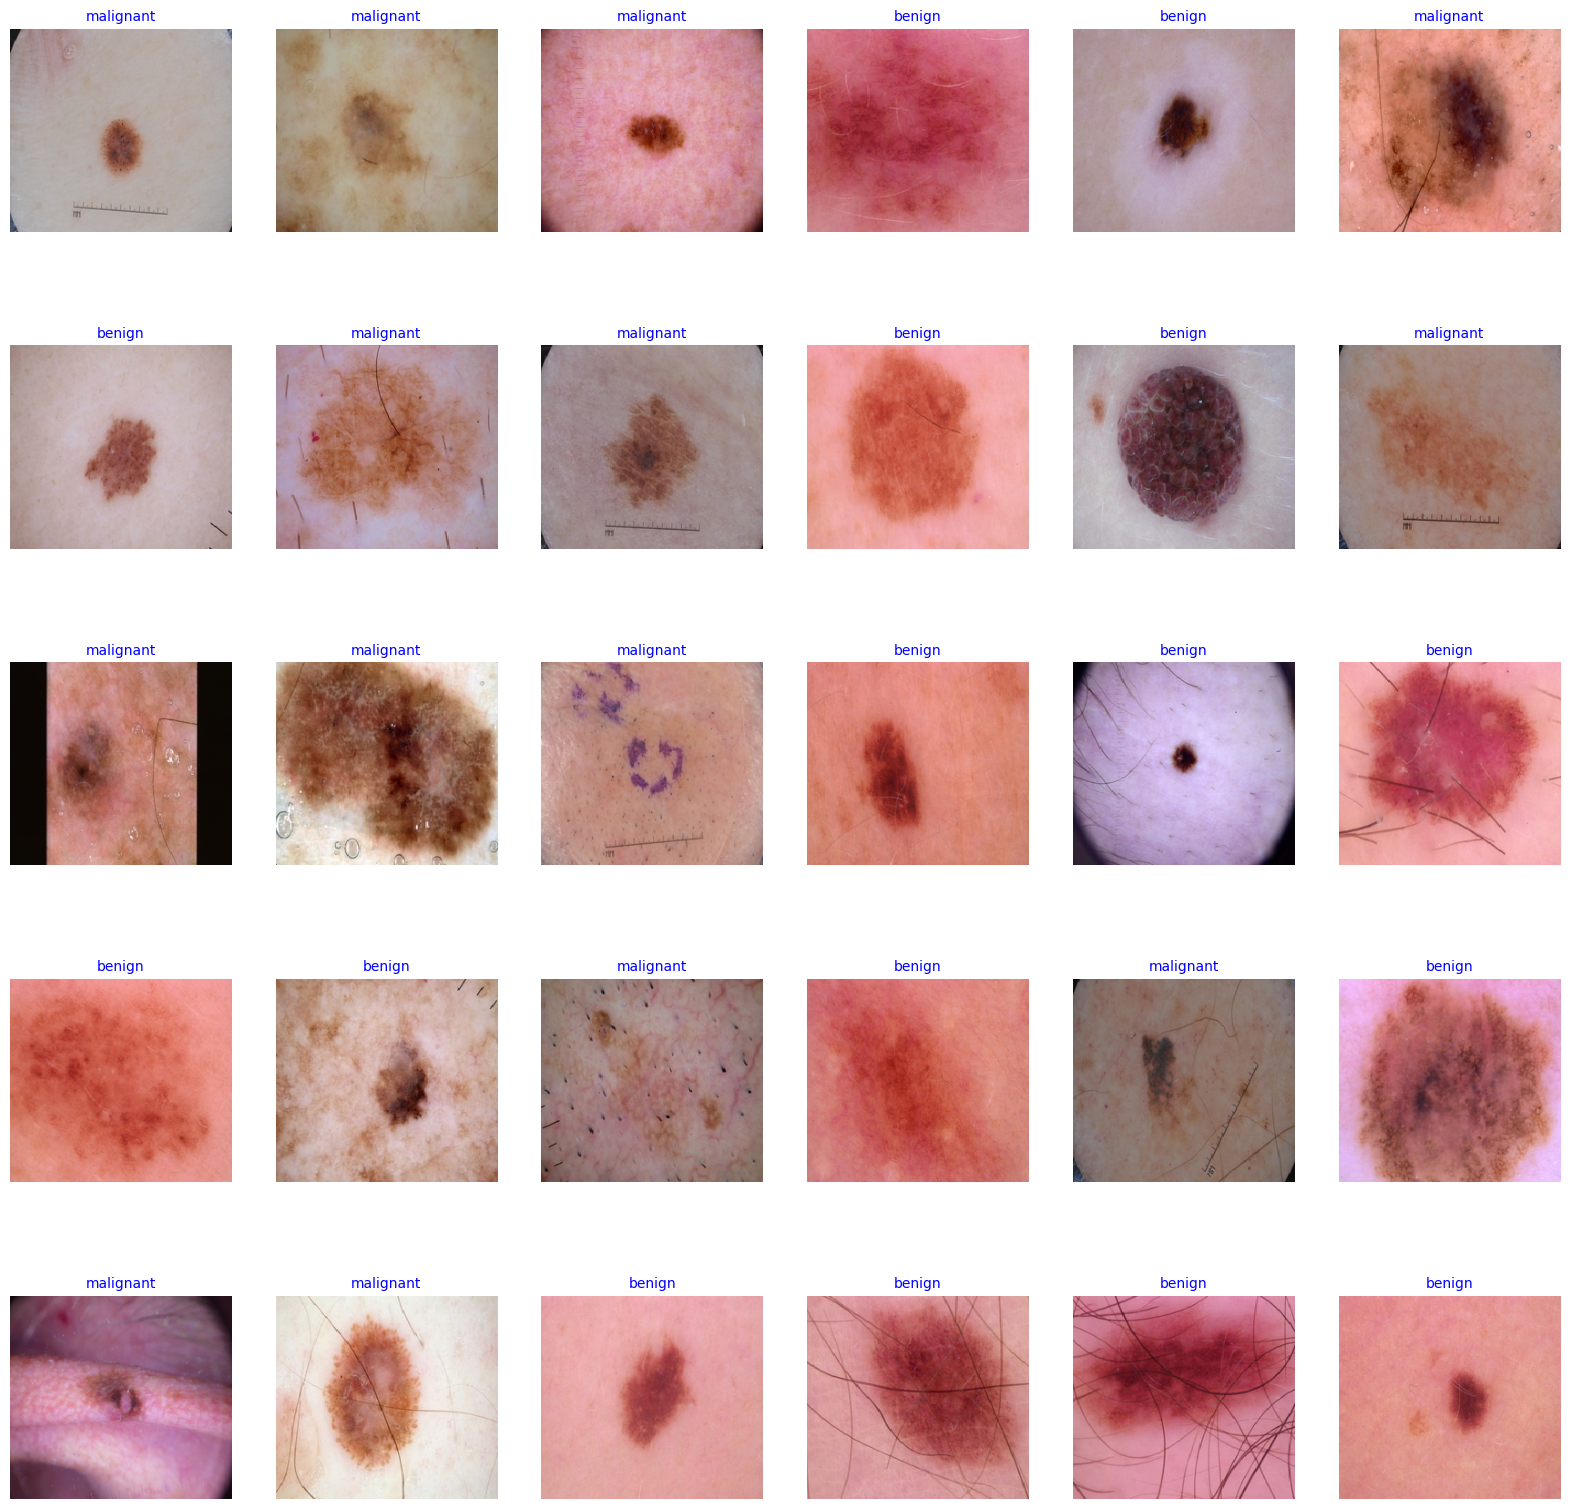

In [12]:
g_dict = train_data.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_data)      # get a batch size samples from the generator
# # difference between next iterator and for iterator


plt.figure(figsize= (20, 24))

for i in range(30):
    plt.subplot(6, 6, i + 1)
    image = images[i]
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 10)
    plt.axis('off')

In [13]:
base_model  = tf.keras.applications.EfficientNetB1(weights = "imagenet", include_top = False, pooling = "avg")

27018416/27018416 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [14]:
#base_model.trainable = False

model = Sequential([
    Input(shape = (224,224,3)),
    base_model,
    BatchNormalization(),
    Dense(256, activation= 'relu',kernel_regularizer= regularizers.l2(0.016),bias_regularizer = regularizers.l1(0.000001),
         activity_regularizer = regularizers.l1(0.000001)),
    Dropout(0.45, seed = 7),
    Dense(2, activation= 'softmax')
])


model.compile(optimizer = keras.optimizers.Adamax(learning_rate = 0.001), loss="categorical_crossentropy",metrics=["accuracy"])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb1 (Functional)     │ (None, 1280)           │     6,575,239 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,908,809 (26.36 MB)

 Trainable params: 6,844,194 (26.11 MB)

 Non-trainable params: 64,615 (252.41 KB)

In [15]:
check_point = ModelCheckpoint('efficientNet_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  
    factor=0.5,          
    patience=5,          
    min_lr=1e-7,        
    verbose=1       
)

In [17]:
history = model.fit(
    train_data,
    epochs=50,
    validation_data=val_data,
    callbacks=[check_point, reduce_lr]
)

Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7388 - loss: 6.8935

c:\Users\CDKVF7A\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



66/66 ━━━━━━━━━━━━━━━━━━━━ 180s 3s/step - accuracy: 0.7395 - loss: 6.8840 - val_accuracy: 0.5455 - val_loss: 5.5354 - learning_rate: 0.0010
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 180s 3s/step - accuracy: 0.8937 - loss: 4.8136 - val_accuracy: 0.5455 - val_loss: 4.5360 - learning_rate: 0.0010
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 187s 3s/step - accuracy: 0.9265 - loss: 3.7792 - val_accuracy: 0.5455 - val_loss: 3.9059 - learning_rate: 0.0010
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1140s 17s/step - accuracy: 0.9530 - loss: 3.0621 - val_accuracy: 0.5455 - val_loss: 4.0552 - learning_rate: 0.0010
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 182s 3s/step - accuracy: 0.9727 - loss: 2.5031 - val_accuracy: 0.5455 - val_loss: 3.4631 - learning_rate: 0.0010
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 177s 3s/step - accuracy: 0.9833 - loss: 2.0436 - val_accuracy: 0.5455 - val_loss: 2.9122 - learning_rate: 0.0010
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 189s 3s/step - accuracy: 0.9832 - loss: 1.7018 - val_accuracy: 0.

In [18]:
vals = pd.DataFrame(history.history)
vals = vals.rename(columns={"loss":"Train Loss","val_loss":"Validation Loss",
                            "accuracy":"Train Accuracy","val_accuracy":"Validation Accuracy"})

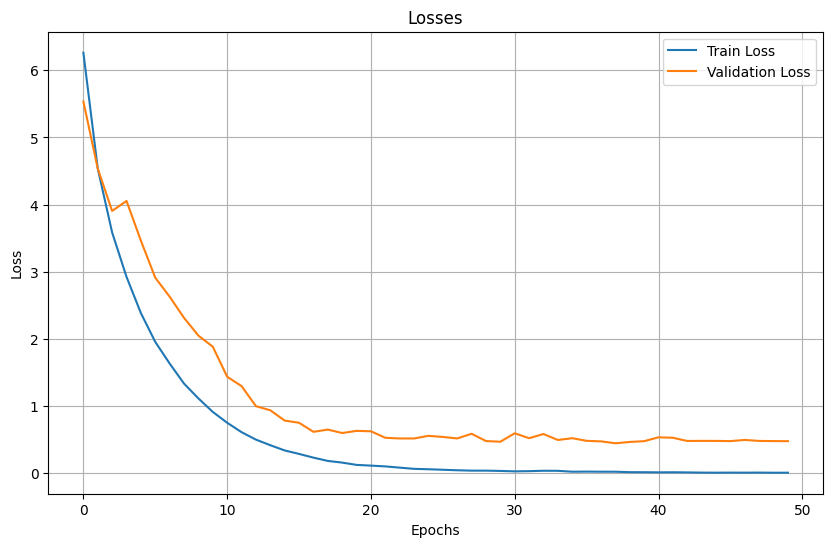

In [23]:
import matplotlib.pyplot as plt
import pandas as pd

# Plot the training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(vals.index, vals["Train Loss"], label="Train Loss")
plt.plot(vals.index, vals["Validation Loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Losses")
plt.legend()
plt.grid(True)
plt.show()

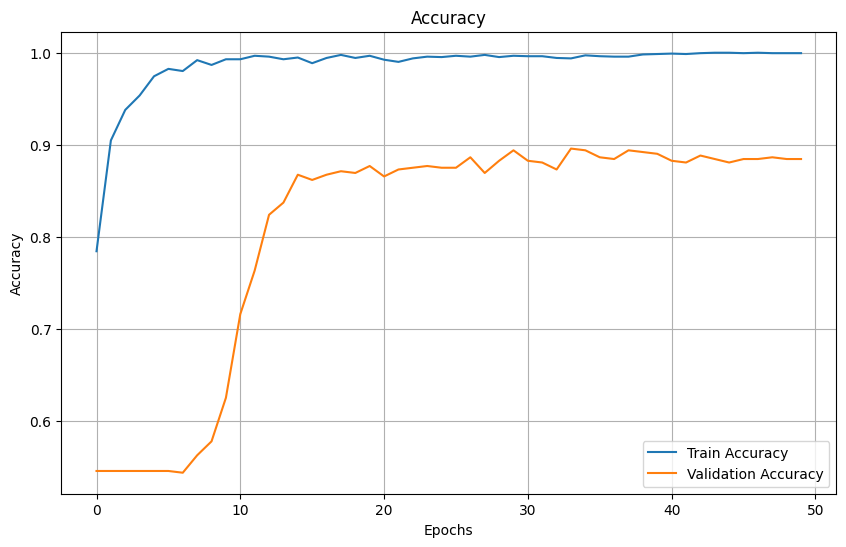

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(vals.index, vals["Train Accuracy"], label="Train Accuracy")
plt.plot(vals.index, vals["Validation Accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

In [25]:
y_true = test_data.classes

# Get predictions
y_pred = model.predict(test_data, steps=len(test_data))
y_pred_classes = np.argmax(y_pred, axis=1)

c:\Users\CDKVF7A\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 498ms/step


In [26]:
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=['Benign', 'Malignant']))

Classification Report:
              precision    recall  f1-score   support

      Benign       0.92      0.90      0.91       360
   Malignant       0.88      0.91      0.89       300

    accuracy                           0.90       660
   macro avg       0.90      0.90      0.90       660
weighted avg       0.90      0.90      0.90       660



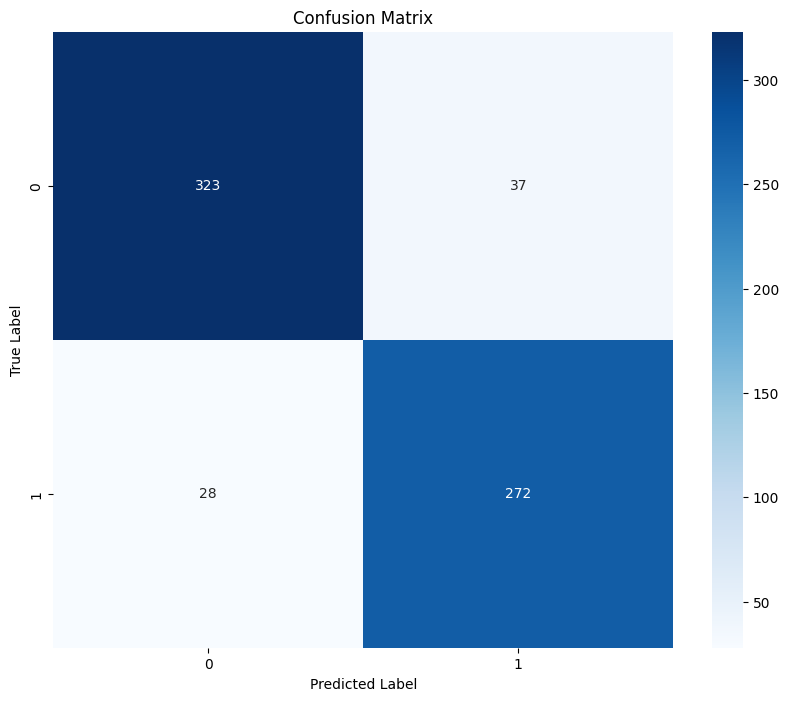

In [27]:
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

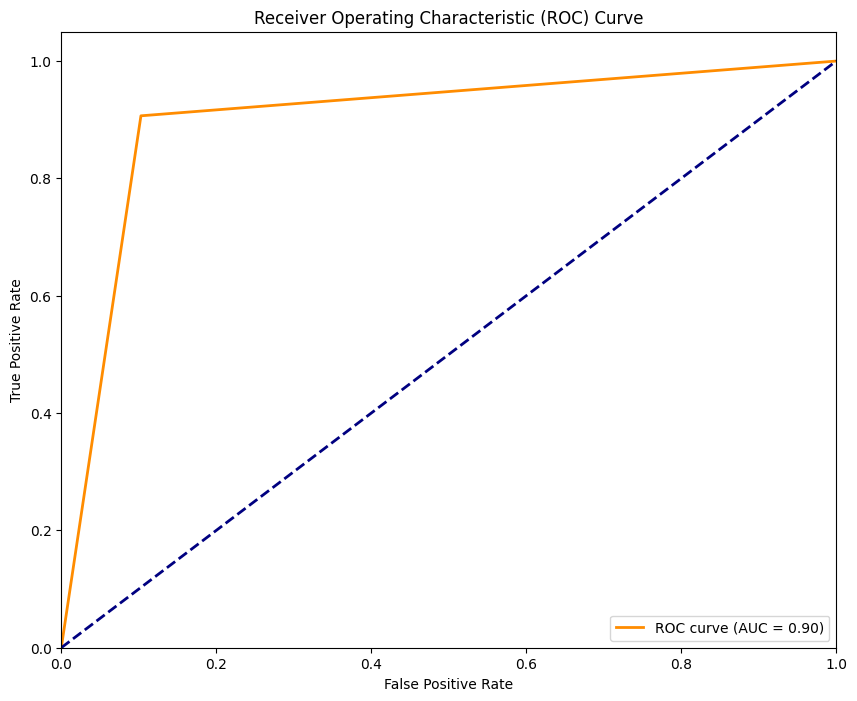

In [28]:
fpr, tpr, thresholds = roc_curve(y_true, y_pred_classes)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()